In [1]:
import json
import h5py
import numpy as np
from torch import nn
import torch
from torch import stft
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import PIL



def load_recording(path_to_h5):
    """
    Returns: 
        eeg data: np.array of type np.float32 with shape (4, X)"
        metadata: dict
    """
    with h5py.File(path_to_h5, "r") as f:
        assert list(f.keys()) == ['eeg4_datasetName'], f"expected structure to be ['eeg4_datasetName'], got {f.keys()}"
        data = f['eeg4_datasetName']
        data_dtype = np.dtype([('timestamp_name', '<u4'), ('eeg1_name', '<f4'), ('eeg2_name', '<f4'), ('eeg3_name', '<f4'), ('eeg4_name', '<f4')])
        assert data.dtype == data_dtype, f"expected dtype to be {data_dtype}, got {data.dtype}"
        # assert (data['timestamp_name'] == np.arange(data.shape[0]) * 4).all(), f"expected timestamp_name to be 0, 4, 8 ... (len(data) - 1) * 4, but got {data['timestamp_name'][:5]}... failed in {(1 * ~(data['timestamp_name'] == np.arange(data.shape[0]) * 4)).sum()} / {data.shape[0]} positions"
        timestamps = data['timestamp_name'] 
        final_data = np.vstack([data['eeg1_name'], data['eeg2_name'], data['eeg3_name'], data['eeg4_name']])
        
        meta = dict(f['eeg4_datasetName'].attrs.items())
        assert list(meta.keys()) == ['eeg4_datasetAttribute', 'eeg4_datasetAttributeStartTime'], f"expected metadata to have keys ['eeg4_datasetAttribute', 'eeg4_datasetAttributeStartTime'], got {meta.keys()}"
        meta['eeg4_datasetAttribute'] = json.loads(meta['eeg4_datasetAttribute'])
        assert meta['eeg4_datasetAttribute']['channelCount'] == 4, f"expected data to have 4 channels. got {meta['eeg4_datasetAttribute']['channelCount']}"
        
        return final_data, timestamps, meta

In [7]:

sample_files = ['/home/ubuntu/small_data/small_data/link-016df838-c633-44c3-b8b9-b7ab7d27f895--994809a0-66da-4f86-894e-eea4adbb77a5_1703511748082_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-02662e8a-027d-4fa4-b4d0-995e00939507--d4574202-0b42-4002-8300-5a3a28f03853_1703759634899_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-02d9b416-6442-4a54-82da-10b2d9ee3e95--389ac5ef-48e9-4aa9-ba9f-667d3a3f93f0_1705770926423_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-0311138e-192b-45e0-97be-d016aeeeb6f6--5795b6e4-a39a-402d-8a7e-5bf5803f7c6c_1707478687789_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-0377963b-eac7-4a04-a5fc-2705dc46c88e--273b725c-f4b5-4b54-89e2-18768e193079_1703195056872_session_eeg.h5']

"/home/ubuntu/small_data/small_data/link-03ebd7cf-69b5-45c2-9516-6fa454fa9a8b--c5024dcc-835f-4c66-b9f1-b7b863781f28_1705868749090_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-046c5899-ed8e-472b-9c4f-62d01c59f7b5--a1979d86-55bc-40f6-b0db-24331cf5fd85_1706280887198_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-0476e1f2-0dea-4ce3-988e-824c0ab7903c--3aef32ec-e5dc-430d-9711-a19f1570f656_1707315417457_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-048ff38b-c902-48e0-918c-b04d5905d932--c2865aa5-d35d-4303-901b-8068b043dc6e_1703655818120_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-0510a54c-bc6e-4d5d-9975-83cec1446e31--2c16de89-aef2-464b-94a5-3a85a85f5b5a_1706079381006_session_eeg.h5",

In [143]:
!ls /home/ubuntu/small_data/small_data/

link-016df838-c633-44c3-b8b9-b7ab7d27f895--994809a0-66da-4f86-894e-eea4adbb77a5_1703511748082_session_eeg.h5
link-02662e8a-027d-4fa4-b4d0-995e00939507--d4574202-0b42-4002-8300-5a3a28f03853_1703759634899_session_eeg.h5
link-02d9b416-6442-4a54-82da-10b2d9ee3e95--389ac5ef-48e9-4aa9-ba9f-667d3a3f93f0_1705770926423_session_eeg.h5
link-0311138e-192b-45e0-97be-d016aeeeb6f6--5795b6e4-a39a-402d-8a7e-5bf5803f7c6c_1707478687789_session_eeg.h5
link-0377963b-eac7-4a04-a5fc-2705dc46c88e--273b725c-f4b5-4b54-89e2-18768e193079_1703195056872_session_eeg.h5
link-03ebd7cf-69b5-45c2-9516-6fa454fa9a8b--c5024dcc-835f-4c66-b9f1-b7b863781f28_1705868749090_session_eeg.h5
link-046c5899-ed8e-472b-9c4f-62d01c59f7b5--a1979d86-55bc-40f6-b0db-24331cf5fd85_1706280887198_session_eeg.h5
link-0476e1f2-0dea-4ce3-988e-824c0ab7903c--3aef32ec-e5dc-430d-9711-a19f1570f656_1707315417457_session_eeg.h5
link-048ff38b-c902-48e0-918c-b04d5905d932--c2865aa5-d35d-4303-901b-8068b043dc6e_1703655818120_session_eeg.h5
link-0510a54c-bc6e-

In [9]:
sample_data = []
for el in sample_files:
    t, _, _ = load_recording(el)
    t = torch.tensor(t)
    sample_data.append(t)
[x.shape for x in sample_data]

[torch.Size([4, 1724256]),
 torch.Size([4, 1286688]),
 torch.Size([4, 966624]),
 torch.Size([4, 1580960]),
 torch.Size([4, 927040])]

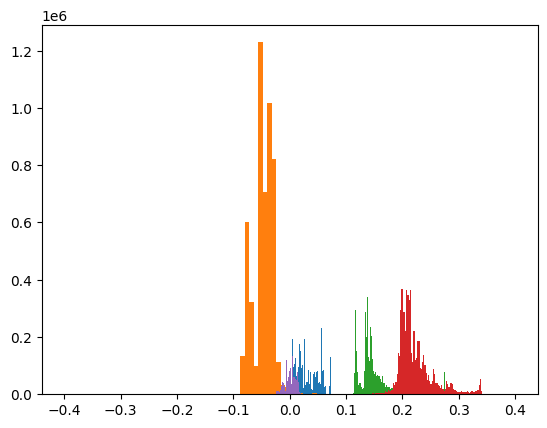

In [16]:
plt.hist(sample_data[0].flatten().numpy(), bins=100)
plt.hist(sample_data[1].flatten().numpy(), bins=100)
plt.hist(sample_data[2].flatten().numpy(), bins=100)
plt.hist(sample_data[3].flatten().numpy(), bins=100)
plt.hist(sample_data[4].flatten().numpy(), bins=100)
None

In [17]:
from torchaudio.functional import highpass_biquad, bandreject_biquad

proc_data = []
for d in sample_data:
    data = highpass_biquad(d, 250, 1) 
    data = bandreject_biquad(data, 250, 50)
    data = bandreject_biquad(data, 250, 100)
    data = data[:, 500:]
    proc_data.append(data)

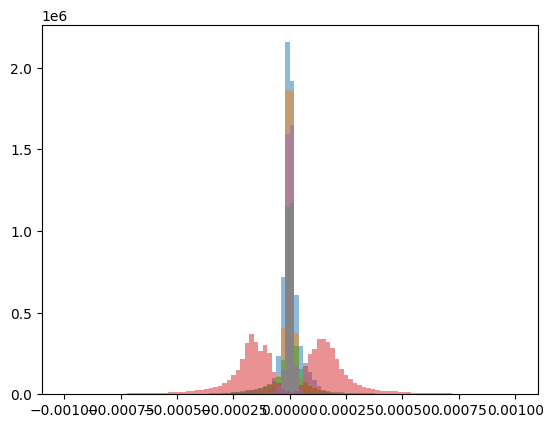

In [40]:
for i in range(5):
    plt.hist(proc_data[i].flatten().numpy(), bins=100, range=(-0.001, 0.001), alpha=0.5)
None

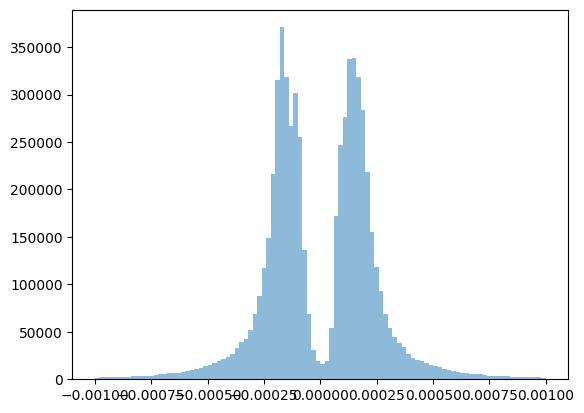

In [38]:
# for i in range(5):
plt.hist(proc_data[3].flatten().numpy(), bins=100, range=(-0.001, 0.001), alpha=0.5)
None

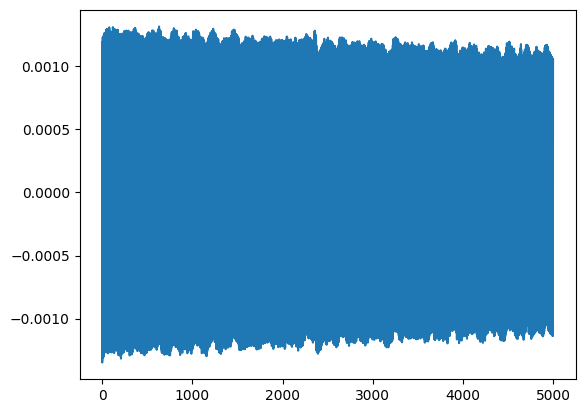

In [55]:
for i in range(1):
    plt.plot(range(5000), proc_data[3][i, :5000]) # proc_data[3].size(1)

In [3]:
def plot_spec(data, n_fft=250, hop_length=125):
    """Input: 1d torch tensor. Assumes 250hz sampling frequency. Returns PIL.Image"""
    assert len(data.shape) == 1, f"expected 1d input, got shape: {data.shape}"
    spec = stft(data, n_fft=n_fft, window=torch.hann_window(n_fft), hop_length=hop_length, center=False, return_complex=True)
    spec = torch.view_as_real(spec)
    spec = torch.sqrt((spec * spec).sum(2))
    
    freqs = torch.linspace(0, data.shape[0]/250, spec.shape[1])
    times = torch.linspace(0, 125, spec.shape[0])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolor(freqs, times, spec, shading='auto',
               norm=LogNorm(vmin=max(spec.min().item(), 1e-9), vmax=max(spec.max().item(), 1e-9)))
    fig.colorbar(c, ax=ax)
    
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    fig.canvas.draw()
    res = PIL.Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    plt.close()
    return res

plot_spec(proc_data[3][0, :5000])

# Im tired of filtering all of this

Lets just discard everything above 50hz

ps 40hz

In [77]:
from torchaudio.functional import highpass_biquad, lowpass_biquad

pd = []
for d in sample_data:
    data = highpass_biquad(d, 250, 1) 
    data = lowpass_biquad(data, 250, 45, Q=300)
    data = data[:, 500:]
    pd.append(data)

/tmp/ipykernel_1922/2034706230.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  res = PIL.Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())


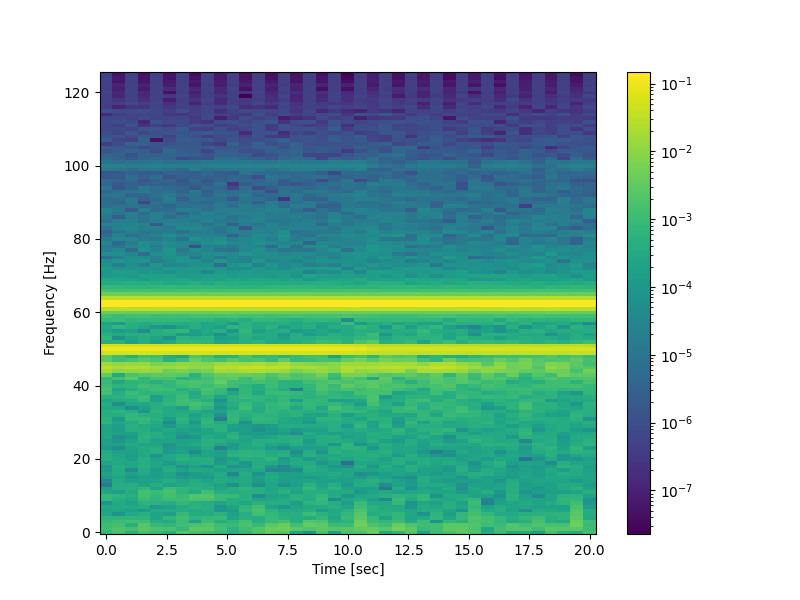

In [79]:
plot_spec(pd[3][0, 5000:10000])

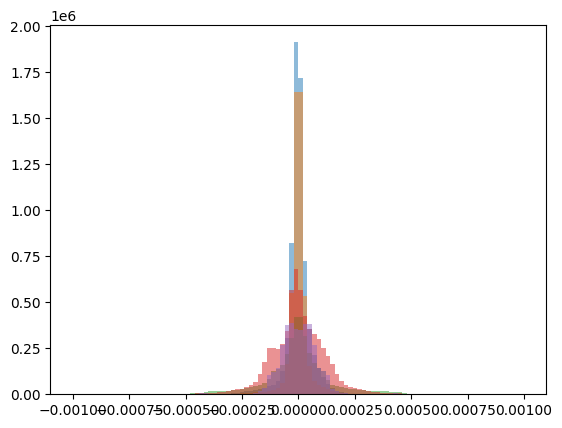

In [65]:
for i in range(5):
    plt.hist(pd[i].flatten().numpy(), bins=100, range=(-0.001, 0.001), alpha=0.5)
None

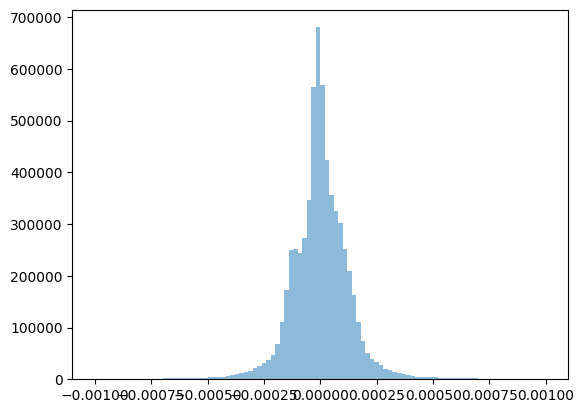

In [66]:
plt.hist(pd[3].flatten().numpy(), bins=100, range=(-0.001, 0.001), alpha=0.5)
None

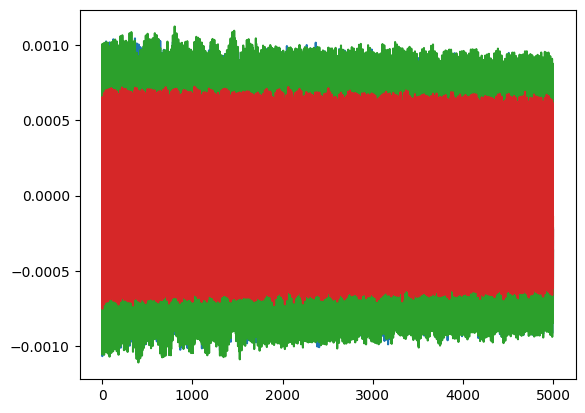

In [67]:
for i in range(4):
    plt.plot(range(5000), pd[3][i, :5000]) # proc_data[3].size(1)

/tmp/ipykernel_1922/2034706230.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  res = PIL.Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())


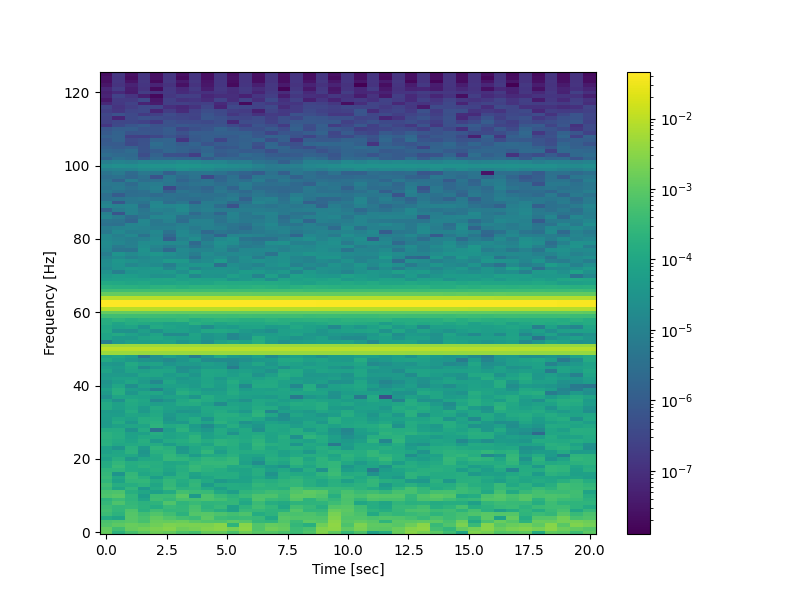

In [68]:
plot_spec(pd[3][0, :5000])

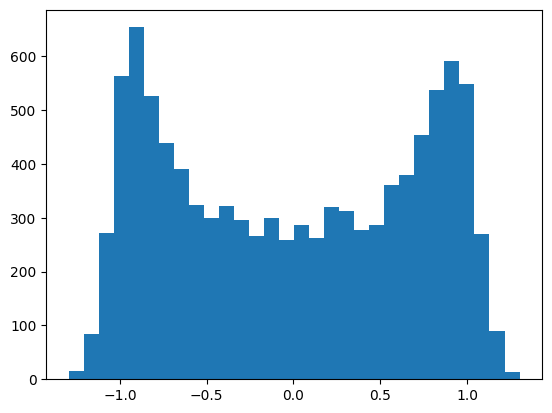

In [82]:
d = torch.sin(torch.arange(10000)) + torch.randn(10000) / 10

plt.hist(d, bins=30)
None

In [7]:
import numpy as np
import scipy.signal as signal

def filter_pass(data, sr, btype, cutoff, order=4):
    """
    Applies a specified filter to the input data using second-order sections for stability.

    Parameters:
    - data: numpy array, can be multichannel.
    - sr: int, the sample rate.
    - btype: str, type of filter ('low' or 'high').
    - cutoff: float, the cutoff frequency.
    - order: int, the order of the filter (default is 4).

    Returns:
    - filtered_data: numpy array, the filtered data.
    """
    nyquist = 0.5 * sr
    normalized_cutoff = cutoff / nyquist
    sos = signal.butter(order, normalized_cutoff, btype=btype, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data, axis=-1)
    return filtered_data


pd = []
for d in sample_data:
    data = d.numpy()
    sr = 250
    data = filter_pass(data, sr, 'high', 1)
    data = filter_pass(data, sr, 'low', 40, 25)
    data = data[:, 500:]
    data = torch.tensor(data.copy())
    pd.append(data)


NameError: name 'sample_data' is not defined

In [4]:

sample_files = [
'/home/ubuntu/small_data/small_data/link-016df838-c633-44c3-b8b9-b7ab7d27f895--994809a0-66da-4f86-894e-eea4adbb77a5_1703511748082_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-02662e8a-027d-4fa4-b4d0-995e00939507--d4574202-0b42-4002-8300-5a3a28f03853_1703759634899_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-02d9b416-6442-4a54-82da-10b2d9ee3e95--389ac5ef-48e9-4aa9-ba9f-667d3a3f93f0_1705770926423_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-0311138e-192b-45e0-97be-d016aeeeb6f6--5795b6e4-a39a-402d-8a7e-5bf5803f7c6c_1707478687789_session_eeg.h5',
'/home/ubuntu/small_data/small_data/link-0377963b-eac7-4a04-a5fc-2705dc46c88e--273b725c-f4b5-4b54-89e2-18768e193079_1703195056872_session_eeg.h5',

"/home/ubuntu/small_data/small_data/link-03ebd7cf-69b5-45c2-9516-6fa454fa9a8b--c5024dcc-835f-4c66-b9f1-b7b863781f28_1705868749090_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-046c5899-ed8e-472b-9c4f-62d01c59f7b5--a1979d86-55bc-40f6-b0db-24331cf5fd85_1706280887198_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-0476e1f2-0dea-4ce3-988e-824c0ab7903c--3aef32ec-e5dc-430d-9711-a19f1570f656_1707315417457_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-048ff38b-c902-48e0-918c-b04d5905d932--c2865aa5-d35d-4303-901b-8068b043dc6e_1703655818120_session_eeg.h5",
"/home/ubuntu/small_data/small_data/link-0510a54c-bc6e-4d5d-9975-83cec1446e31--2c16de89-aef2-464b-94a5-3a85a85f5b5a_1706079381006_session_eeg.h5",
]

In [8]:
pd10 = []
for sf in sample_files:
    data, _, _ = load_recording(sf)
    sr = 250
    data = filter_pass(data, sr, 'high', 1)
    data = filter_pass(data, sr, 'low', 40, 25)
    data = data[:, 500:]
    data = torch.tensor(data.copy())
    pd10.append(data)
    

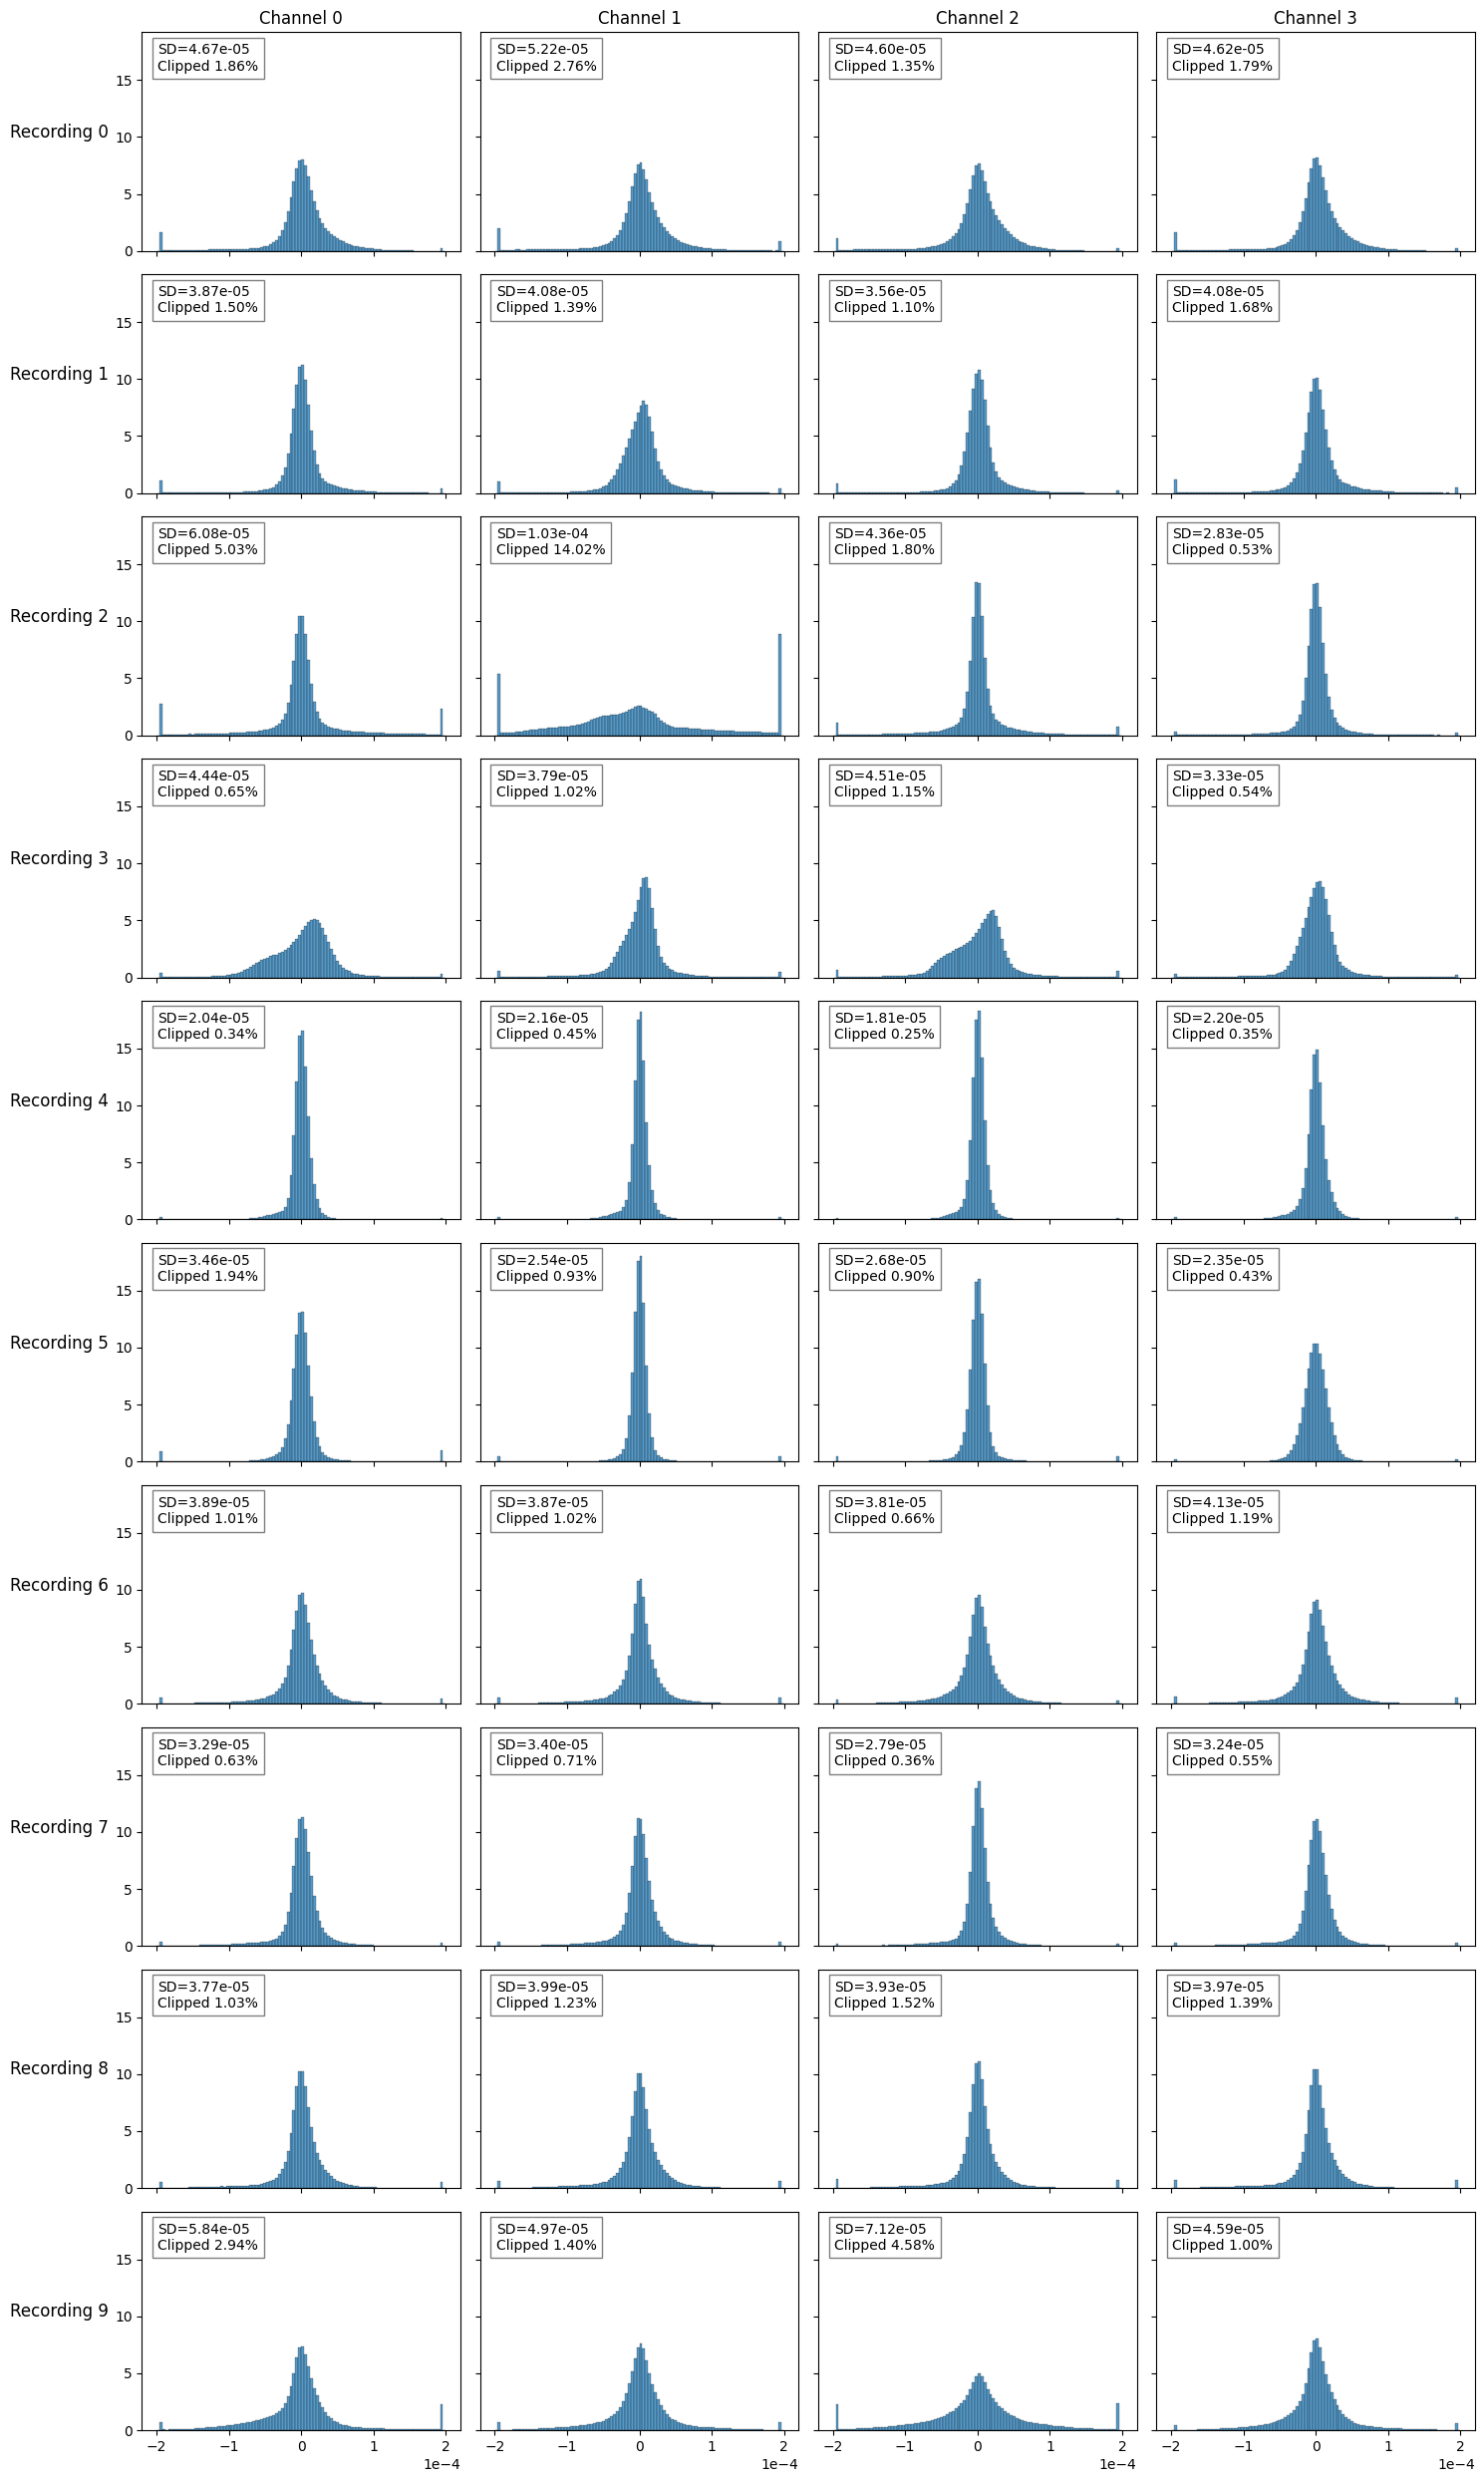

In [14]:
import seaborn as sns

_, axs = plt.subplots(nrows=10, ncols=4, figsize=(15, 25), sharey=True, sharex=True)

for i in range(10):
    for ch in range(4):
        data = pd10[i][ch, :].numpy()
        data = np.clip(data, -1.95e-4, 1.95e-4)
        sns.histplot(data, bins=100, binrange=(-0.0002, 0.0002), stat='percent', ax=axs[i][ch])
        axs[i][ch].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        
        part_clipped = (np.abs(data) > 1.94e-4).sum() / data.shape[0]
        axs[i][ch].text(0.05, 0.95, f'SD={np.std(data):.2e}\nClipped {100 * part_clipped:.2f}%', transform=axs[i][ch].transAxes,
                        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        
        

# Add column titles for channels
for ax, col in zip(axs[0], ['Channel 0', 'Channel 1', 'Channel 2', 'Channel 3']):
    ax.set_title(col)

# Add row titles for recordings
for ax, row in zip(axs[:, 0], [f'Recording {i}' for i in range(10)]):
    ax.set_ylabel(row, rotation=0, size='large', labelpad=40)

plt.tight_layout()
plt.show()

None

In [23]:
data

tensor([-5.2105e-05, -4.4905e-05, -2.8503e-05,  ..., -5.1669e-06,
        -1.6899e-05, -3.0859e-05], dtype=torch.float64)

Text(0.5, 0, 'seconds')

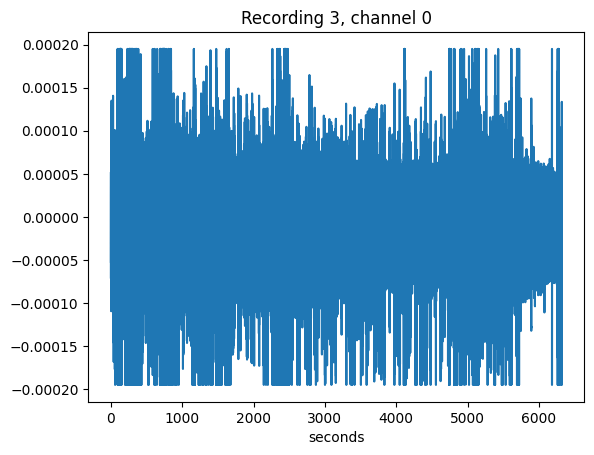

In [24]:
data = pd10[3][0, :]
data = np.clip(data, -1.95e-4, 1.95e-4)
plt.plot(np.arange(data.shape[0]) / 250, data)
plt.title('Recording 3, channel 0')
plt.xlabel('seconds')

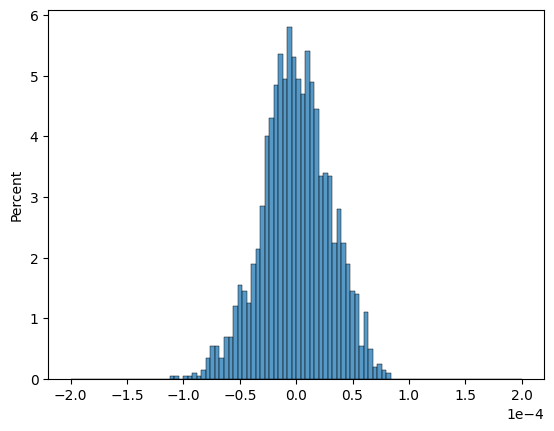

In [20]:
sns.histplot(data, bins=100, binrange=(-0.0002, 0.0002), stat='percent', )
plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        

In [39]:
(np.abs(data) > 1.94e-4).sum() / data.shape[0]

tensor(0.0503)

In [57]:
type(data)

numpy.ndarray

In [72]:
from numba import njit

data = pd10[2][0, :].numpy()
data = np.clip(data, -1.95e-4, 1.95e-4)


@njit
def return_clipping_parts(d: np.ndarray, join_close = 250):
    section_start = -1
    res = []
    for i in range(d.shape[0]):
        if section_start == -1:  # Not in a section
            if d[i]:
                section_start = i
        else:  # In a section
            if not d[i]:
                res.append((section_start, i))
                section_start = -1
    # Handle case where the clipping section goes till the end of the array
    if section_start != -1:
        res.append((section_start, d.shape[0]))
        
    fix_res = []
    cur_start = res[0][0]           # [0, 1] [3, 5] V [100, 105] V [117, 200]
    for i in range(1, len(res)):
        if res[i][0] - res[i-1][1] > join_close:
            fix_res.append((cur_start, res[i-1][1]))
            cur_start = res[i][0]
    fix_res.append((cur_start, res[-1][1]))
    
    return fix_res

@njit
def get_viable_parts(data: np.ndarray, join_close):
    clipped_sections = []
    for i in range(4):
        clipped_sections.append(return_clipping_parts[i, :], join_close)
    joined_clipped_sections = []
    # join clipped sections
    return joined_clipped_sections

    

clipped = np.abs(data) > 1.94e-4
clipping_parts = return_clipping_parts(clipped)
for el in print(clipping_parts)

SyntaxError: expected ':' (1117221506.py, line 36)

In [71]:
clipped[clipping_parts]

array([[ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False]])

/tmp/ipykernel_1599/300706176.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  res = PIL.Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())


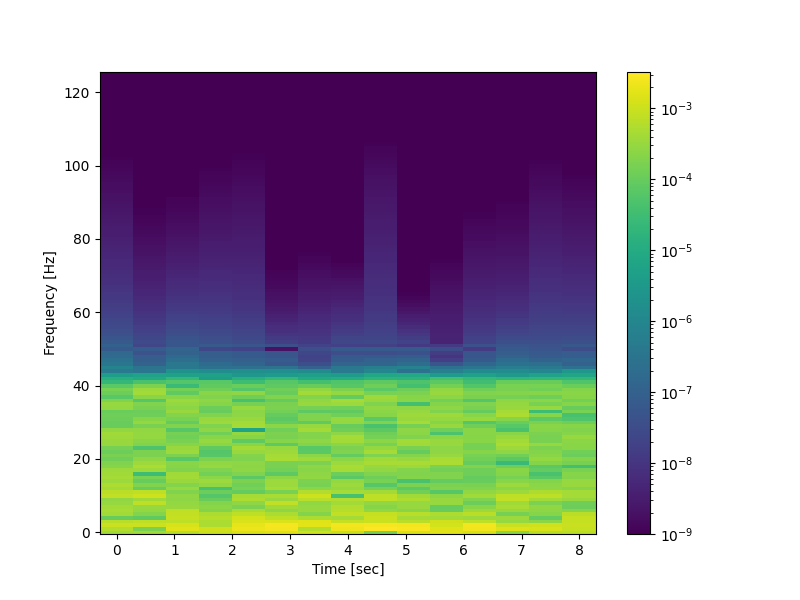

In [17]:
data = pd10[3][0, :250 * 8]
data = np.clip(data, -1.95e-4, 1.95e-4)
plot_spec(data)

Text(0.5, 0, 'seconds')

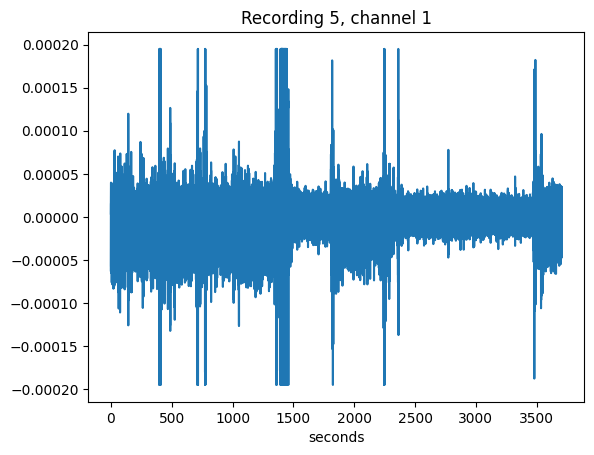

In [158]:
data = pd10[4][0, :]
data = np.clip(data, -1.95e-4, 1.95e-4)
plt.plot(np.arange(data.shape[0]) / 250, data)
plt.title('Recording 5, channel 1')
plt.xlabel('seconds')

In [ ]:
data = pd10[3][0, :]
data = np.clip(data, -1.95e-4, 1.95e-4)
plt.plot(np.arange(data.shape[0]) / 250, data)
plt.title('Recording 4, channel 1')
plt.set_xlabel('seconds')

In [151]:
for i in range(10):
    print(f'recording #{i}')
    for ch in range(4):
        print(f"ch {ch}: {100 * (torch.abs(pd[i][ch, :]) > 1e-4).sum() / pd[i].size(1):.2f}%")

recording #0
ch 0: 5.51%
ch 1: 7.16%
ch 2: 5.11%
ch 3: 5.33%
recording #1
ch 0: 3.73%
ch 1: 3.89%
ch 2: 2.97%
ch 3: 4.13%
recording #2
ch 0: 10.80%
ch 1: 32.97%
ch 2: 5.28%
ch 3: 1.80%
recording #3
ch 0: 3.27%
ch 1: 3.37%
ch 2: 4.17%
ch 3: 2.48%
recording #4
ch 0: 0.73%
ch 1: 0.93%
ch 2: 0.56%
ch 3: 0.78%
recording #5


IndexError: list index out of range

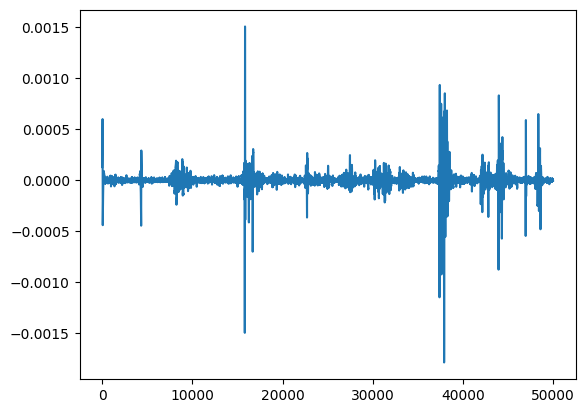

In [135]:
# for i in range(4):
plt.plot(range(50000), pd[2][2, :50000]) # proc_data[3].size(1)

/tmp/ipykernel_1922/2034706230.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  res = PIL.Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())


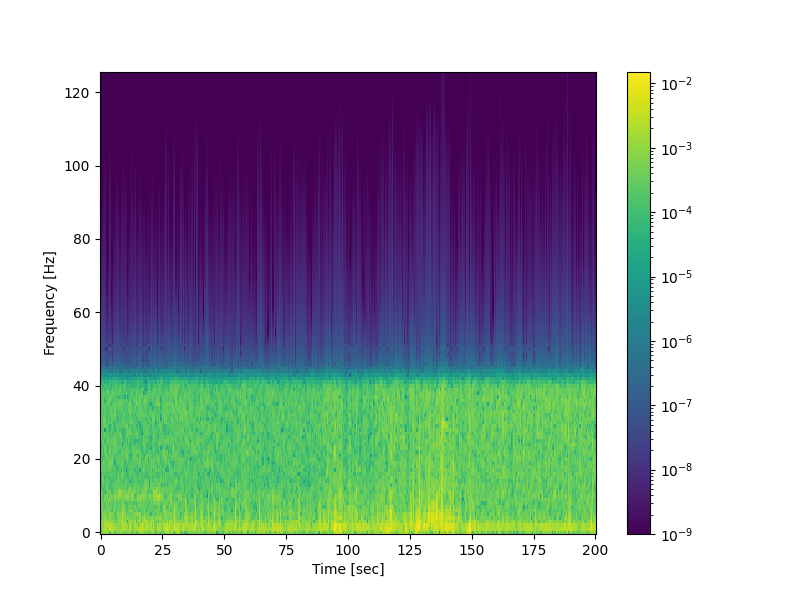

In [134]:
plot_spec(pd[3][0, :50000])